# GOterm enrichment analysis on genes with significant allelic imbalance
# (pseudobulked scRNA)

In [1]:
# Loading libraries
suppressPackageStartupMessages({
  library(openxlsx)
  library(dplyr)
  library(tidyverse)
  library(clusterProfiler)
  library(org.Mm.eg.db)
  library(gridExtra)
})

### CastBl6

In [3]:
#Loading test results
cell_types <- c("Deep layer neurons", "Gliogenic progenitor cells", "Hippocampal neurons", "Inhibitory neurons", 
                "Intermediate neuronal prog", "Neurogenic progenitor cells", "Oligodendrocyte prog", "Preplate neurons")
res_dir <- "/g/data/zk16/veronika/projects/vierbuct/github/data/bbtest_res_ASPEN/updated/"
cast_bb_test <- list()
for (i in 1:length(cell_types[-3])){
  cast_bb_test[[i]] <- read.xlsx(paste0(res_dir, "organoids_CAST_exons.xlsx"), sheet = i, rowNames = T)
  cast_bb_test[[i]]$cell_type <- cell_types[-3][i]
  cast_bb_test[[i]]$strain <- "CastB6"
}

#becasuse clone 1 and clone2 were processed differently, gliogenic progenitors did not have sufficient number of genes expressing in that cell type
#to compensate for that, clone1 and clone2 were excluded from the allelic imbalance testing
#four extra columns are added to gliogenic progenitor cells to make the number of columns between the objects equal
cast_bb_test[[2]]$BL6_CastxBl6_clone1 <- 0
cast_bb_test[[2]]$BL6_CastxBl6_clone2 <- 0
cast_bb_test[[2]]$CastxBl6_clone1 <- 0
cast_bb_test[[2]]$CastxBl6_clone2 <- 0
cast_bb_test[[2]] <- cast_bb_test[[2]][,c(1:3, 35:36, 4:5, 37:38, 6:34)]

### MolfBl6

In [4]:
molf_bb_test <- list()
for (i in 1:length(cell_types)){
  molf_bb_test[[i]] <- read.xlsx(paste0(res_dir, "organoids_MOLF_exons.xlsx"), sheet = i, rowNames = T)
  molf_bb_test[[i]]$cell_type <- cell_types[i]
  molf_bb_test[[i]]$strain <- "MolfB6"
}

molf_bb_test[[2]]$BL6_MolfxBl6_clone1 <- 0
molf_bb_test[[2]]$BL6_MolfxBl6_clone2 <- 0
molf_bb_test[[2]]$MolfxBl6_clone1 <- 0
molf_bb_test[[2]]$MolfxBl6_clone2 <- 0
molf_bb_test[[2]] <- molf_bb_test[[2]][,c(1:3, 35:36, 4:5, 37:38, 6:34)]


### PwkBl6

In [5]:
#Hippocamal neurons are not present in PWK data
pwk_bb_test <- list()
for (i in 1:length(cell_types[-3])){
  pwk_bb_test[[i]] <- read.xlsx(paste0(res_dir, "organoids_PWK_exons.xlsx"), sheet = i, rowNames = T)
  pwk_bb_test[[i]]$cell_type <- cell_types[-3][i]
  pwk_bb_test[[i]]$strain <- "PwkB6"
}

pwk_bb_test[[2]]$BL6_PwkxBl6_clone1 <- 0
pwk_bb_test[[2]]$BL6_PwkxBl6_clone2 <- 0
pwk_bb_test[[2]]$PwkxBl6_clone1 <- 0
pwk_bb_test[[2]]$PwkxBl6_clone2 <- 0
pwk_bb_test[[2]] <- pwk_bb_test[[2]][,c(1:3, 35:36, 4:5, 37:38, 6:34)]


### SpretBl6

In [6]:
spret_bb_test <- list()
for (i in 1:length(cell_types)){
  spret_bb_test[[i]] <- read.xlsx(paste0(res_dir, "organoids_SPRET_exons.xlsx"), sheet = i, rowNames = T)
  spret_bb_test[[i]]$cell_type <- cell_types[i]
  spret_bb_test[[i]]$strain <- "SpretB6"
}

spret_bb_test[[2]]$BL6_SpretxBl6_clone1 <- 0
spret_bb_test[[2]]$BL6_SpretxBl6_clone2 <- 0
spret_bb_test[[2]]$SpretxBl6_clone1 <- 0
spret_bb_test[[2]]$SpretxBl6_clone2 <- 0
spret_bb_test[[2]] <- spret_bb_test[[2]][,c(1:3, 35:36, 4:5, 37:38, 6:34)]


In [7]:
#removing low-abundant cell types - Hippocampal neurons, Inhibitory neurons and Preplate neurons
cast_bb_test <- cast_bb_test[-3]
molf_bb_test <- molf_bb_test[-c(3,4)]
pwk_bb_test <- pwk_bb_test[-3]
spret_bb_test <- spret_bb_test[-c(3,4)]

genesXY <- read.table("/data/mm10_genesXY.txt")
genesIMPR <- read.xlsx("/data/Some_imprinted_genes.xlsx")

genes.exclude <- genesXY$V1

In [8]:
#removing ribosomal genes
genes.use.cast <- list()
genes.use.molf <- list()
genes.use.pwk <- list()
genes.use.spret <- list()
for (i in 1:length(cast_bb_test)){
  genes.use.cast[[i]] <- grep(pattern = "^Rp[sl][[:digit:]]|^Rp[[:digit:]]|^Rpsa|^Rplp[[:digit:]]|^Rrpl|^Rp[lp][[:digit:]]|^Gm[[:digit:]]|Rik|-ps|^Rb|^Mrps[[:digit:]]|^Mrpl[[:digit:]]|^Snrp|^Rrs[[:digit:]]|^Zpf[[:digit:]]",
                              rownames(cast_bb_test[[i]]),
                              value=TRUE, invert=TRUE)
  cast_bb_test[[i]] <- cast_bb_test[[i]][genes.use.cast[[i]],]
  cast_bb_test[[i]] <- cast_bb_test[[i]][!(rownames(cast_bb_test[[i]]) %in% genes.exclude),]
  genes.use.molf[[i]] <- grep(pattern = "^Rp[sl][[:digit:]]|^Rp[[:digit:]]|^Rpsa|^Rplp[[:digit:]]|^Rrpl|^Rp[lp][[:digit:]]|^Gm[[:digit:]]|Rik|-ps|^Rb|^Mrps[[:digit:]]|^Mrpl[[:digit:]]|^Snrp|^Rrs[[:digit:]]|^Zpf[[:digit:]]",
                              rownames(molf_bb_test[[i]]),
                              value=TRUE, invert=TRUE)
  molf_bb_test[[i]] <- molf_bb_test[[i]][genes.use.molf[[i]],]
  molf_bb_test[[i]] <- molf_bb_test[[i]][!(rownames(molf_bb_test[[i]]) %in% genes.exclude),]
  genes.use.pwk[[i]] <- grep(pattern = "^Rp[sl][[:digit:]]|^Rp[[:digit:]]|^Rpsa|^Rplp[[:digit:]]|^Rrpl|^Rp[lp][[:digit:]]|^Gm[[:digit:]]|Rik|-ps|^Rb|^Mrps[[:digit:]]|^Mrpl[[:digit:]]|^Snrp|^Rrs[[:digit:]]|^Zpf[[:digit:]]",
                             rownames(pwk_bb_test[[i]]),
                             value=TRUE, invert=TRUE)
  pwk_bb_test[[i]] <- pwk_bb_test[[i]][genes.use.pwk[[i]],]
  pwk_bb_test[[i]] <- pwk_bb_test[[i]][!(rownames(pwk_bb_test[[i]]) %in% genes.exclude),]
  genes.use.spret[[i]] <- grep(pattern = "^Rp[sl][[:digit:]]|^Rp[[:digit:]]|^Rpsa|^Rplp[[:digit:]]|^Rrpl|^Rp[lp][[:digit:]]|^Gm[[:digit:]]|Rik|-ps|^Rb|^Mrps[[:digit:]]|^Mrpl[[:digit:]]|^Snrp|^Rrs[[:digit:]]|^Zpf[[:digit:]]",
                               rownames(spret_bb_test[[i]]),
                               value=TRUE, invert=TRUE)
  spret_bb_test[[i]] <- spret_bb_test[[i]][genes.use.spret[[i]],]
  spret_bb_test[[i]] <- spret_bb_test[[i]][!(rownames(spret_bb_test[[1]]) %in% genes.exclude),]
}

In [9]:
#selecting genes with significant fdr and ordering them by fdr
sign_genes_cast <- lapply(cast_bb_test,function(q) q %>% filter(fdr_shrunk <= 0.05)
                          %>% arrange(fdr_shrunk)) #- indicates decreasing order
sign_genes_molf <- lapply(molf_bb_test,function(q) q %>% filter(fdr_shrunk <= 0.05)
                          %>% arrange(fdr_shrunk))
sign_genes_pwk <- lapply(pwk_bb_test,function(q) q %>% filter(fdr_shrunk <= 0.05)
                         %>% arrange(fdr_shrunk))
sign_genes_spret <- lapply(spret_bb_test,function(q) q %>% filter(fdr_shrunk <= 0.05)
                           %>% arrange(fdr_shrunk))  


#extracting log2FC and gene names
geneids_cast <- lapply(sign_genes_cast, function(q) q %>% rownames_to_column("gene") %>%
                         dplyr::select(gene, log2FC, fdr_shrunk))
geneids_molf <- lapply(sign_genes_molf, function(q) q %>% rownames_to_column("gene") %>%
                         dplyr::select(gene, log2FC, fdr_shrunk))
geneids_pwk <- lapply(sign_genes_pwk, function(q) q %>% rownames_to_column("gene") %>%
                        dplyr::select(gene, log2FC, fdr_shrunk))
geneids_spret <- lapply(sign_genes_spret, function(q) q %>% rownames_to_column("gene") %>%
                          dplyr::select(gene, log2FC, fdr_shrunk))


In [10]:
#converting gene names to ENTREZ IDs
entrezids_cast <- lapply(geneids_cast, function(q) bitr(q$gene, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Mm.eg.db"))
entrezids_molf <- lapply(geneids_molf, function(q) bitr(q$gene, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Mm.eg.db"))
entrezids_pwk <- lapply(geneids_pwk, function(q) bitr(q$gene, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Mm.eg.db"))
entrezids_spret <- lapply(geneids_spret, function(q) bitr(q$gene, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Mm.eg.db"))


#adding log2fc vector to ENTREZ IDs
for (i in 1:length(entrezids_cast)){
  entrezids_cast[[i]]$log2FC <- geneids_cast[[i]]$log2FC[match(entrezids_cast[[i]]$SYMBOL, geneids_cast[[i]]$gene)]
  entrezids_molf[[i]]$log2FC <- geneids_molf[[i]]$log2FC[match(entrezids_molf[[i]]$SYMBOL, geneids_molf[[i]]$gene)]
  entrezids_pwk[[i]]$log2FC <- geneids_pwk[[i]]$log2FC[match(entrezids_pwk[[i]]$SYMBOL, geneids_pwk[[i]]$gene)]
  entrezids_spret[[i]]$log2FC <- geneids_spret[[i]]$log2FC[match(entrezids_spret[[i]]$SYMBOL, geneids_spret[[i]]$gene)]
}


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(q$gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Mm.eg.db"):
“0.9% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(q$gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Mm.eg.db"):
“0.68% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(q$gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Mm.eg.db"):
“0.82% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(q$gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Mm.eg.db"):
“1.04% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(q$gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Mm.eg.db"):
“1.17% of input gene IDs are fail to

In [11]:
#adding fdr values vector to ENTREZ IDs
for (i in 1:length(entrezids_cast)){
  entrezids_cast[[i]]$fdr <- geneids_cast[[i]]$fdr_shrunk[match(entrezids_cast[[i]]$SYMBOL, geneids_cast[[i]]$gene)]
  entrezids_molf[[i]]$fdr <- geneids_molf[[i]]$fdr_shrunk[match(entrezids_molf[[i]]$SYMBOL, geneids_molf[[i]]$gene)]
  entrezids_pwk[[i]]$fdr <- geneids_pwk[[i]]$fdr_shrunk[match(entrezids_pwk[[i]]$SYMBOL, geneids_pwk[[i]]$gene)]
  entrezids_spret[[i]]$fdr <- geneids_spret[[i]]$fdr_shrunk[match(entrezids_spret[[i]]$SYMBOL, geneids_spret[[i]]$gene)]
}


In [12]:
#converting fdr value to be used in lieu of log2FC
geneselect_cast <- lapply(entrezids_cast, function(q) q %>% mutate(-log10(fdr + 1e-15)) %>% #converting logFC to their absolute values
                            arrange(-`-log10(fdr + 1e-15)`) %>% #'-' indicates decreasing order
                            dplyr::select(ENTREZID, `-log10(fdr + 1e-15)`) %>% 
                            deframe())
geneselect_molf <- lapply(entrezids_molf, function(q) q %>% mutate(-log10(fdr + 1e-15)) %>%
                            arrange(-`-log10(fdr + 1e-15)`) %>%
                            dplyr::select(ENTREZID, `-log10(fdr + 1e-15)`) %>% 
                            deframe())
geneselect_pwk <- lapply(entrezids_pwk, function(q) q %>% mutate(-log10(fdr + 1e-15)) %>%
                           arrange(-`-log10(fdr + 1e-15)`) %>%   
                           dplyr::select(ENTREZID, `-log10(fdr + 1e-15)`) %>% 
                           deframe())
geneselect_spret <- lapply(entrezids_spret, function(q) q %>% mutate(-log10(fdr + 1e-15)) %>%
                             arrange(-`-log10(fdr + 1e-15)`) %>%
                             dplyr::select(ENTREZID, `-log10(fdr + 1e-15)`) %>% 
                             deframe())


### Performing Gene Set Enrichment Analysis

In [ ]:
gsea_cast <- lapply(geneselect_cast, function (q) gseGO(geneList=q, 
                                                      ont ="ALL", 
                                                      keyType = "ENTREZID", #keytype of gene
                                                      minGSSize = 15,#3, 
                                                      maxGSSize = 500,#800, 
                                                      pvalueCutoff = 1, 
                                                      verbose = TRUE, 
                                                      OrgDb = org.Mm.eg.db, 
                                                      by = "fgsea", #default, one of 'fgsea' or 'DOSE'
                                                      pAdjustMethod = "fdr"))

saveRDS(gsea_cast, file = "gsea/scRNA_organoids_gsea_cast_updated_onfdr.rds" )  

gsea_molf <- lapply(geneselect_molf, function (q) gseGO(geneList=q, 
                                                      ont ="ALL", 
                                                      keyType = "ENTREZID", #keytype of gene
                                                      minGSSize = 15,#3, 
                                                      maxGSSize = 500,#800, 
                                                      pvalueCutoff = 1, 
                                                      verbose = TRUE, 
                                                      OrgDb = org.Mm.eg.db, 
                                                      by = "fgsea", #default, one of 'fgsea' or 'DOSE'
                                                      pAdjustMethod = "fdr"))

saveRDS(gsea_molf, file = "gsea/scRNA_organoids_gsea_molf_updated_onfdr.rds" )  
                   
gsea_pwk <- lapply(geneselect_pwk, function (q) gseGO(geneList=q, 
                                                      ont ="ALL", 
                                                      keyType = "ENTREZID", #keytype of gene
                                                      minGSSize = 15,#3, 
                                                      maxGSSize = 500,#800, 
                                                      pvalueCutoff = 1, 
                                                      verbose = TRUE, 
                                                      OrgDb = org.Mm.eg.db, 
                                                      by = "fgsea", #default, one of 'fgsea' or 'DOSE'
                                                      pAdjustMethod = "fdr"))

saveRDS(gsea_pwk, file = "gsea/scRNA_organoids_gsea_pwk_updated_onfdr.rds" )  

gsea_spret <- lapply(geneselect_spret, function (q) gseGO(geneList=q, 
                                                          ont ="ALL", 
                                                          keyType = "ENTREZID", #keytype of gene
                                                          minGSSize = 15,#3, 
                                                          maxGSSize = 500,#800, 
                                                          pvalueCutoff = 1, 
                                                          verbose = TRUE, 
                                                          OrgDb = org.Mm.eg.db, 
                                                          by = "fgsea", #default, one of 'fgsea' or 'DOSE'
                                                          pAdjustMethod = "fdr"))

saveRDS(gsea_spret, file = "/gsea/scRNA_organoids_gsea_spret_updated_onfdr.rds" )                   

### Plotting the results

### CastBl6

In [15]:
gsea_cast <- readRDS("/gsea/scRNA_organoids_gsea_cast_updated_onfdr.rds")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


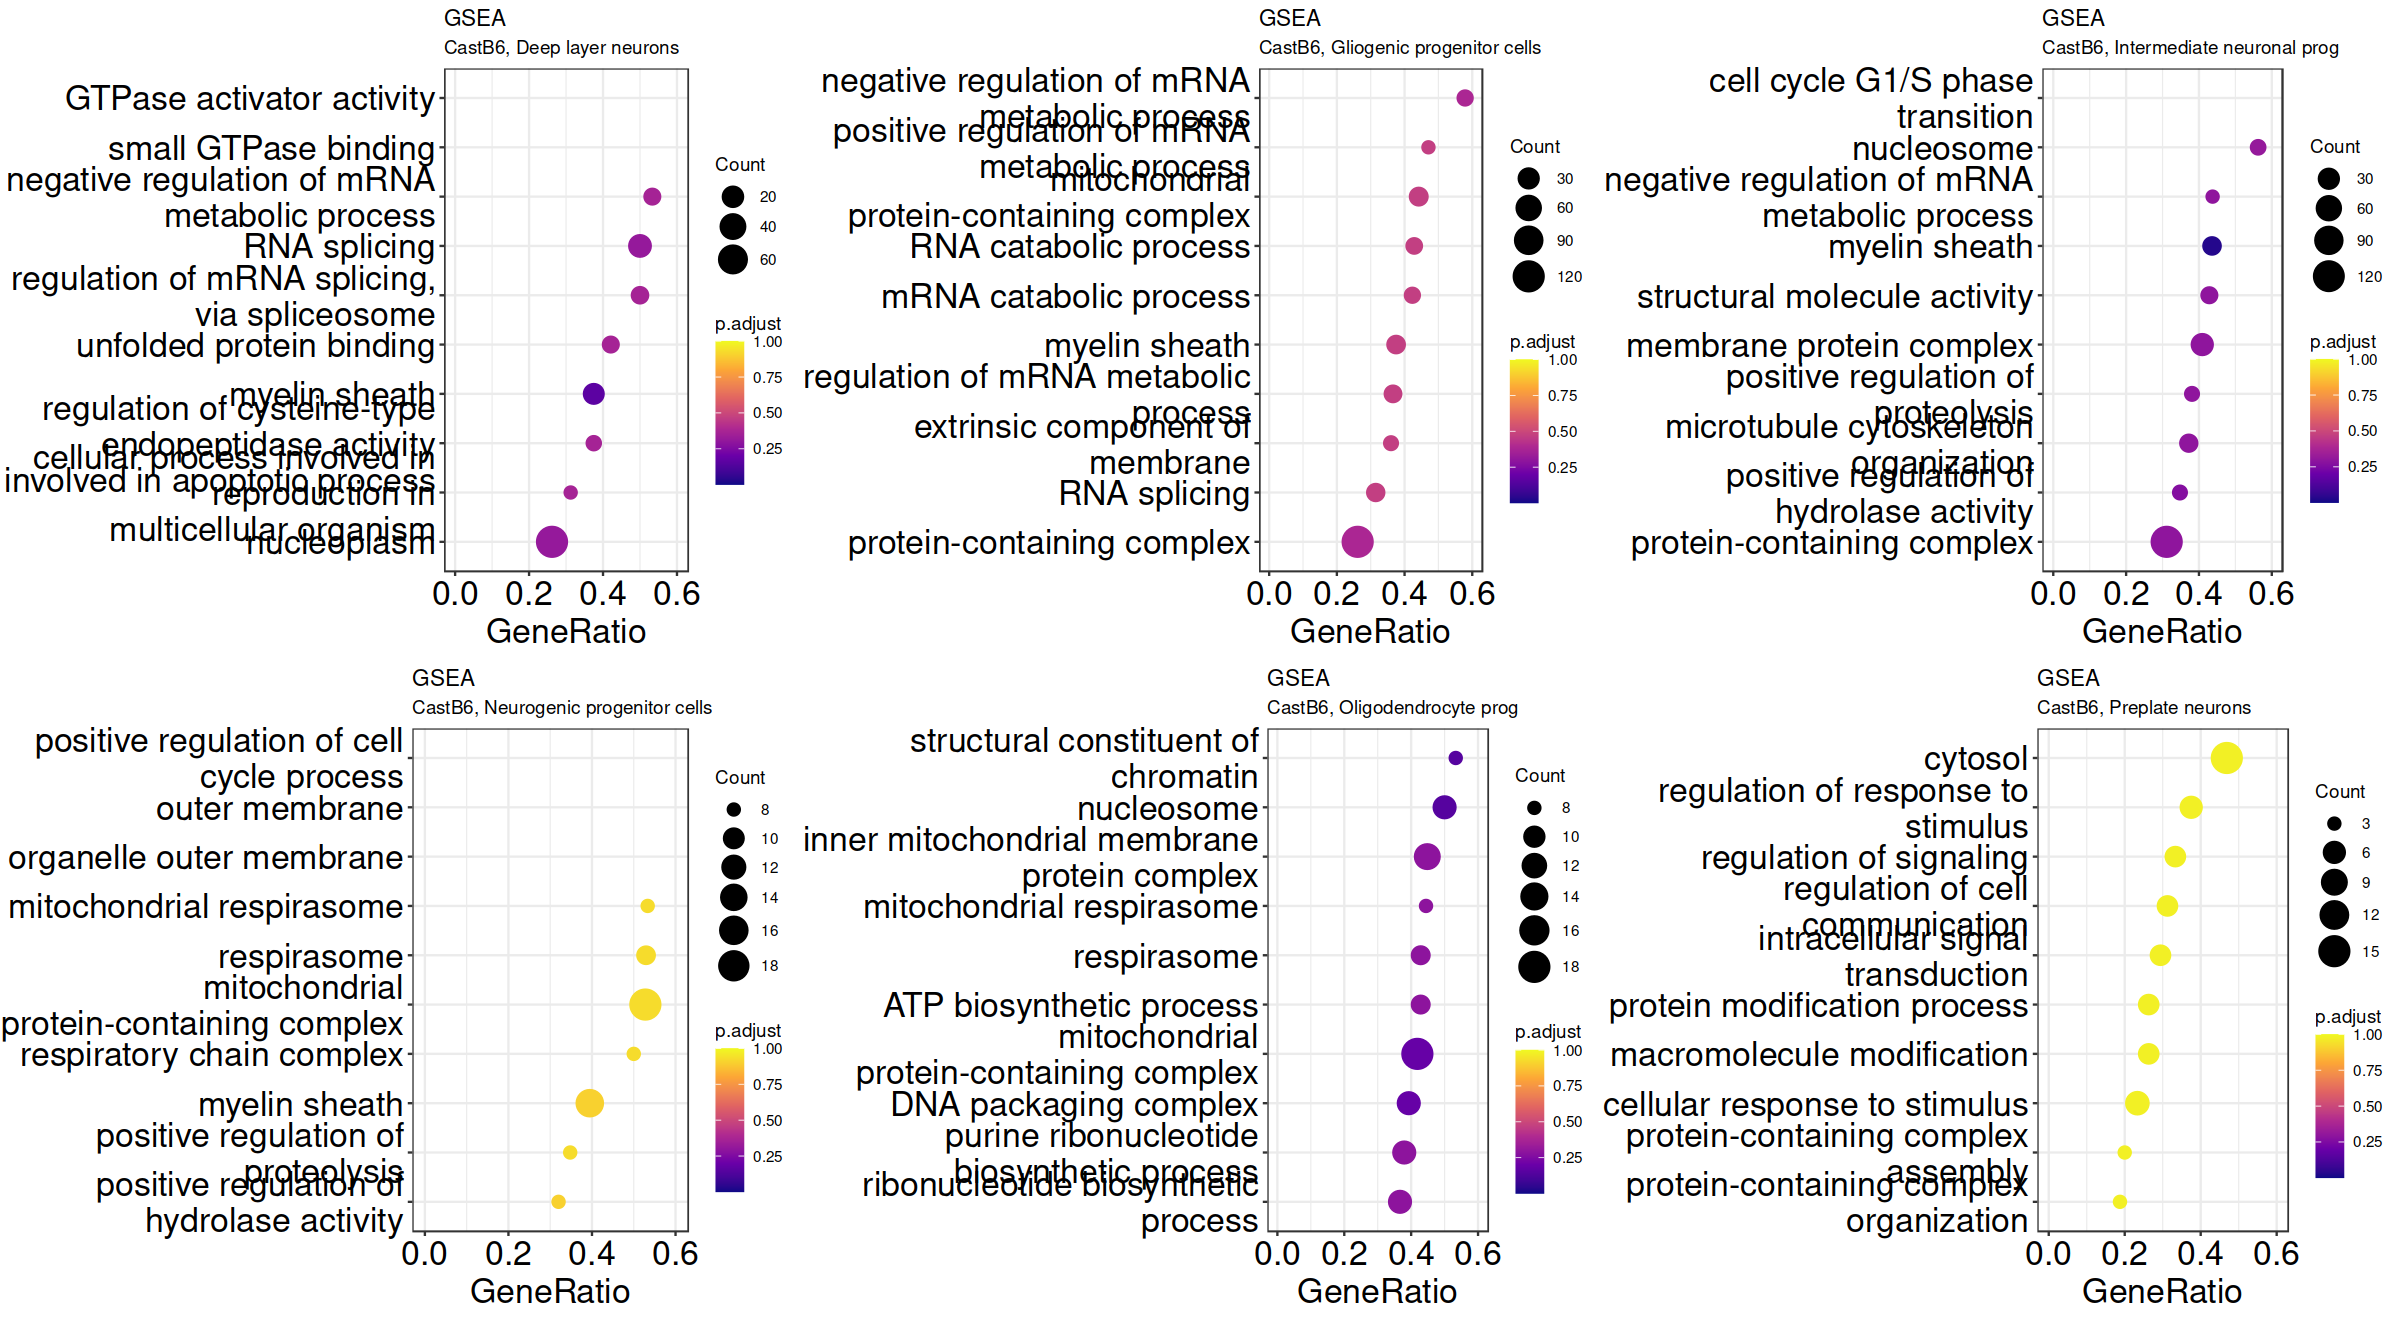

In [19]:
options(repr.plot.width = 20, repr.plot.height = 11)
gsea_cast_plots <- mapply(function(p, q) dotplot(p, showCategory = 10, font.size=20) +
                            scale_color_viridis_c(limits=c(1e-04, 1), option = "plasma") +
                            labs(title = "GSEA", subtitle = paste0("CastB6, ", q)) +
                            xlim(0, 0.6), gsea_cast, cell_types[-c(3,4)], SIMPLIFY = F)
do.call("grid.arrange", c(gsea_cast_plots, ncol = 3))

### MolfBl6

In [20]:
gsea_molf <- readRDS("/gsea/scRNA_organoids_gsea_molf_updated_onfdr.rds")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


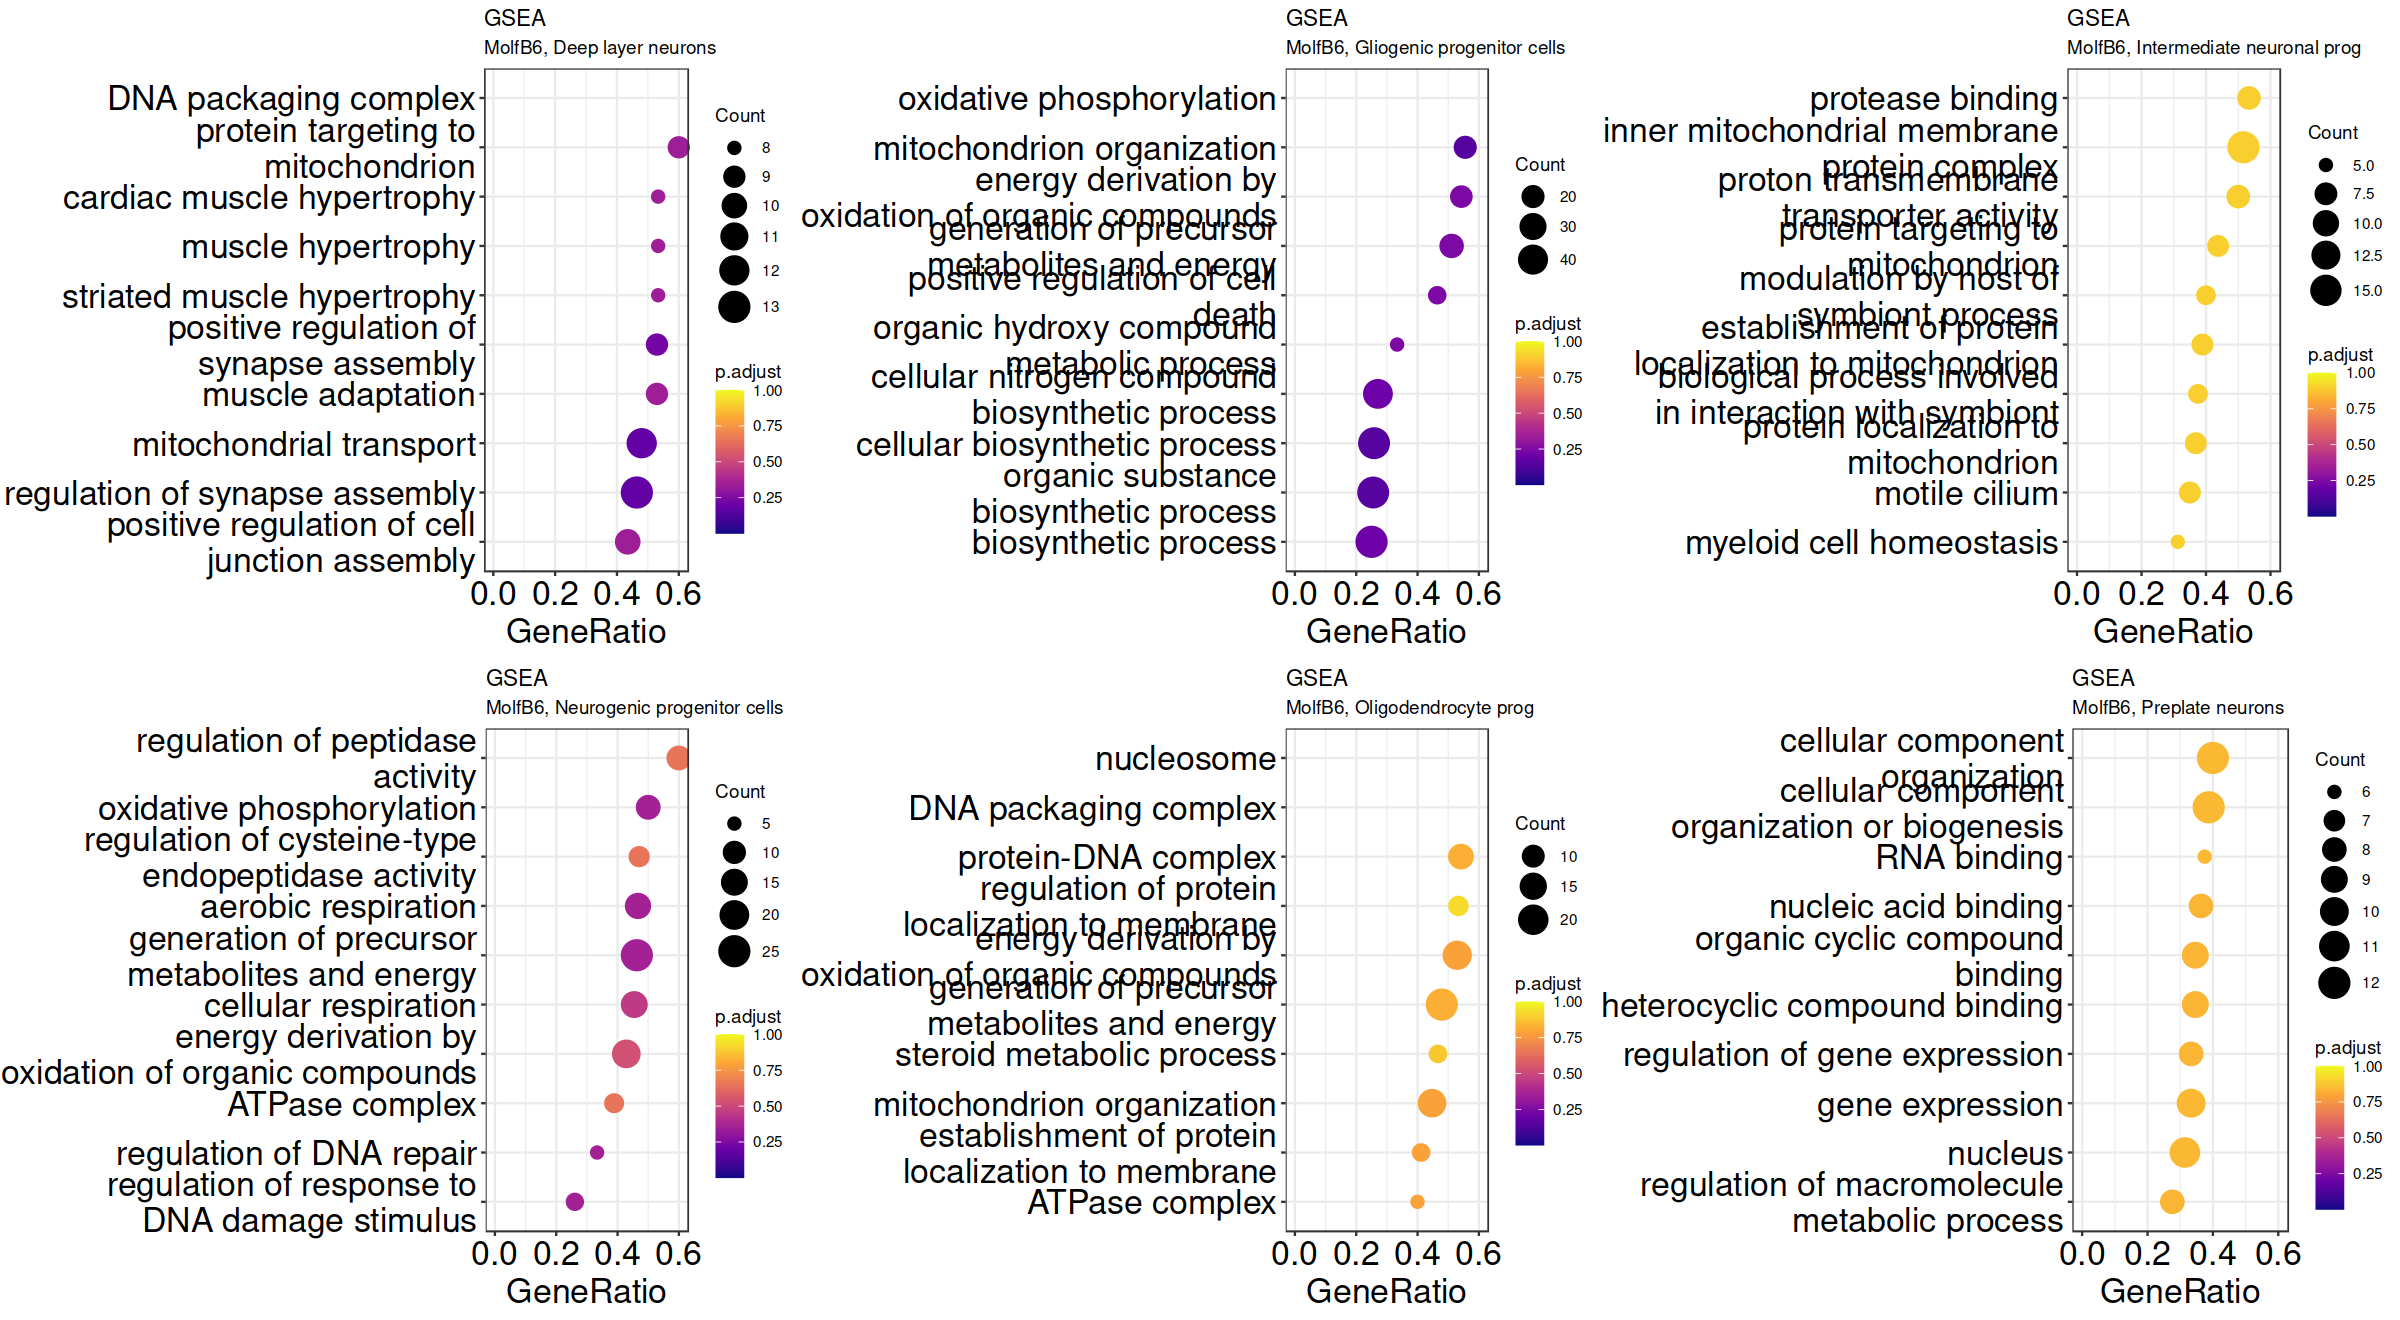

In [21]:
gsea_molf_plots <- mapply(function(p, q) dotplot(p, showCategory = 10, font.size=20) +
                            scale_color_viridis_c(limits=c(1e-04, 1), option = "plasma") +
                            labs(title = "GSEA", subtitle = paste0("MolfB6, ", q)) +
                            xlim(0, 0.6), gsea_molf, cell_types[-c(3,4)], SIMPLIFY = F)
do.call("grid.arrange", c(gsea_molf_plots, ncol = 3))

### PwkBl6

In [22]:
gsea_pwk <- readRDS("/gsea/scRNA_organoids_gsea_pwk_updated_onfdr.rds")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


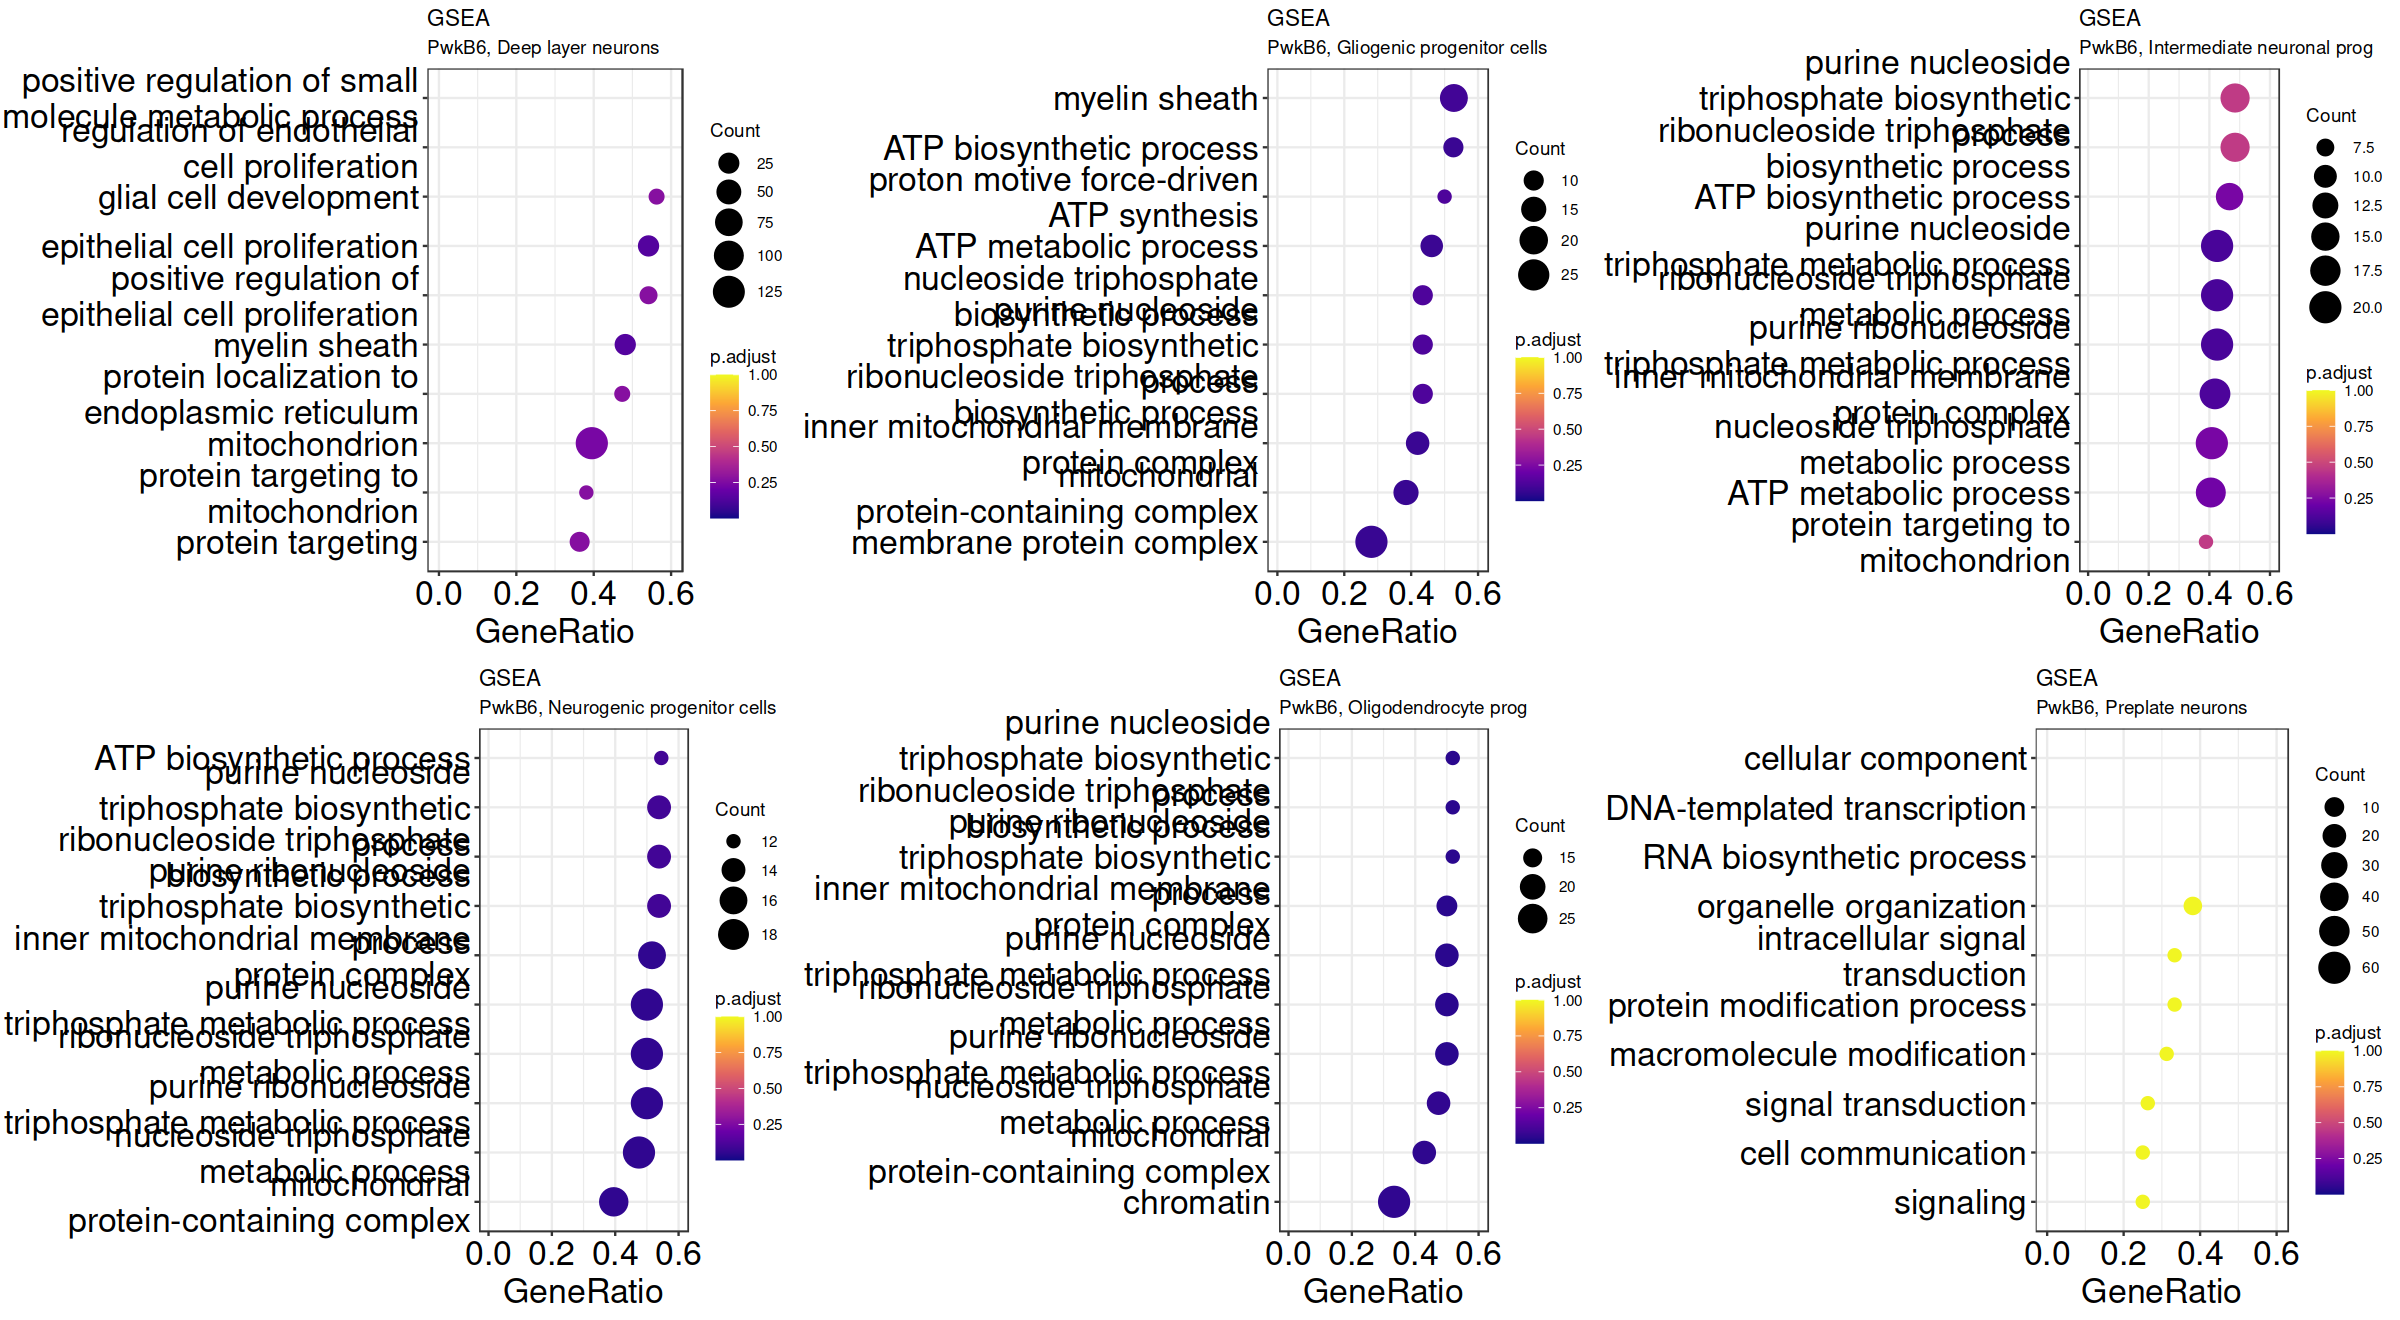

In [23]:
gsea_pwk_plots <- mapply(function(p, q) dotplot(p, showCategory = 10, font.size=20) +
                            scale_color_viridis_c(limits=c(1e-04, 1), option = "plasma") +
                            labs(title = "GSEA", subtitle = paste0("PwkB6, ", q)) +
                            xlim(0, 0.6), gsea_pwk, cell_types[-c(3,4)], SIMPLIFY = F)
do.call("grid.arrange", c(gsea_pwk_plots, ncol = 3))

### SpretBl6

In [24]:
gsea_spret <- readRDS("/gsea/scRNA_organoids_gsea_spret_updated_onfdr.rds")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


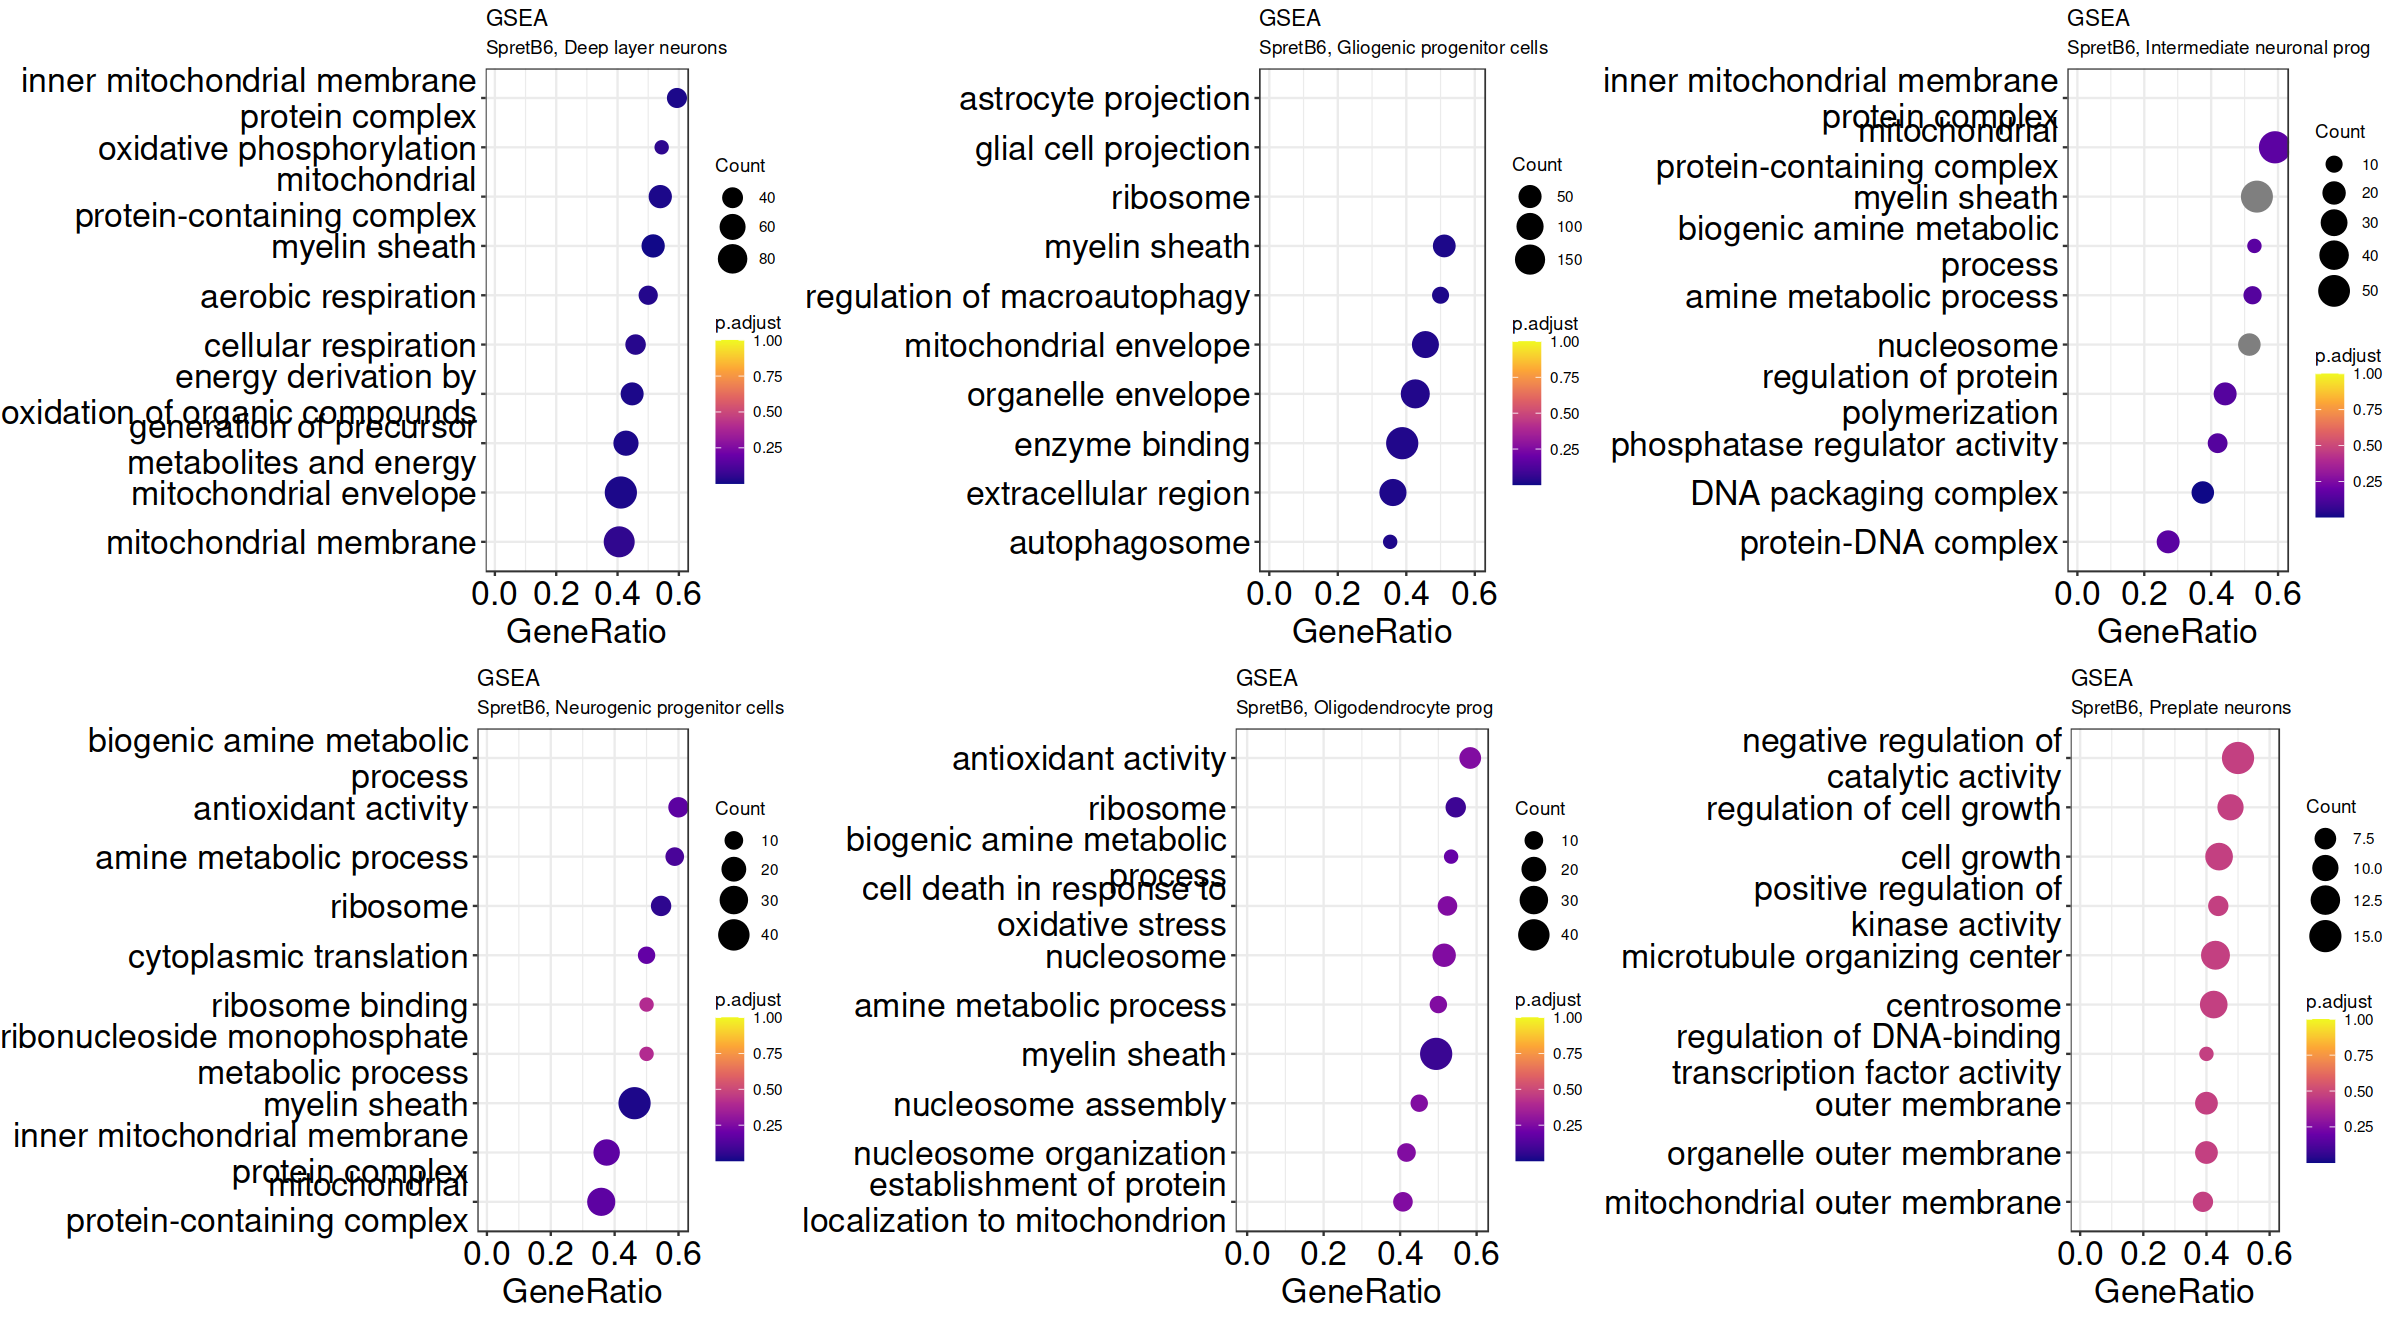

In [25]:
gsea_spret_plots <- mapply(function(p, q) dotplot(p, showCategory = 10, font.size=20) +
                           scale_color_viridis_c(limits=c(1e-04, 1), option = "plasma") +
                           labs(title = "GSEA", subtitle = paste0("SpretB6, ", q)) +
                           xlim(0, 0.6), gsea_spret, cell_types[-c(3,4)], SIMPLIFY = F)
do.call("grid.arrange", c(gsea_spret_plots, ncol = 3))